# Project AirBnB: Extracting Insights using PySpark
 

# The AirBnB dataset

<img src="https://www.esquireme.com/public/images/2019/11/03/airbnb-678x381.jpg" alt="airbnb" width="400"/>

[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In the first three exercises you will use Spark to analyze data obtained from the Airbnb website (stricly speaking via data scraped by [insideairbnb](http://insideairbnb.com/get-the-data.html)). The purpose of my analysis is to extract insights about listings as a whole, specifics about London, and sentiment analysis of reviews (word positivity).


## Loading data
The dataset consists of listings (offered lodgings) and reviews (submitted by users). The `.csv`'s I'll work with vary between the first three exercises, but is structured so that the function below will load it into a spark dataframe.

In [ ]:
def load_csv_as_dataframe(path):
    return spark.read.option('header', True) \
                .option('inferSchema', True) \
                .option('multiLine', 'True') \
                .option('escape', '"') \
                .option('mode', 'DROPMALFORMED')\
                .csv(path)

## Imports and Spark session

* I'll need to adapt the `JAVA_HOME` environment variable to my setup. 
* I should set the `spark.driver.memory` value to the amount of memory on my machine. 

In [ ]:
! sudo apt-get update
! sudo mkdir -p /usr/share/man/man1
! sudo apt-get install -y openjdk-11-jdk
! pip install pyspark

     |████████████████████████████████| 198 kB 52.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=70c8b63fb2020856c278b4e71042f5a51e456554b101bfa3790ab8502c31fb44
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
# Instructions on p. 20 Learning Spark, 2nd ed.
# Here's a quick-guide, googling may also be required
# 1) Install pyspark via conda/pip
#          pyspark requires the JAVA_HOME environment variable is set.
# 2) Install JDK 8 or 11, figure out the install location
#          Suggest to use https://adoptopenjdk.net/
# 3) Update the JAVA_HOME environment variable set programmatically below 
#    with your install location specifics

# JAVA_HOME environment variable is set programatically below
# but you must point it to your local install

import os
#os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home/'

# If you get "Job aborted due to stage failure" and 
# "Python worker failed to connect back." exceptions, 
# this should be solved by additionally setting these 
# environment variables

# os.environ['PYSPARK_PYTHON'] = 'python'
# os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
# os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'notebook'

In [ ]:
!pip install pandasql
!pip install pandas-profiling

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf

from pandas_profiling import ProfileReport

import pandasql as psql

In [ ]:
# Sets memory limit on driver and to use all CPU cores
conf = SparkConf().set('spark.ui.port', '4050') \
        .set('spark.driver.memory', '4g') \
        .setMaster('local[*]')

sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark

In [ ]:
sc.getConf().getAll()

[('spark.driver.memory', '4g'),
 ('spark.driver.host', '640e2b40e21b'),
 ('spark.app.id', 'local-1638122048247'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.app.startTime', '1638122046250'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.port', '40735'),
 ('spark.ui.port', '4050'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Insight 1: Listings and cities


## Part 1: Preparing the dataframe

My data source is [this zip archive](https://data-download.compute.dtu.dk/c02807/listings.csv.zip) which you must uncompress and place in the same folder as this notebook. It is loaded in the next cell and named `df_listings`.

After the data is read, you should select the columns necessary for insights 1, 2 and 3 (by reading ahead or iteratively extend this loading code). Name this dataframe `df_listings_analysis` and make use of caching.

Prices are in local currency, but are nonetheless prefixed with `$` and contains thousands separator commas. You will need to remove these characters and cast the price column to `pyspark.sql.types.DoubleType`. Observe that if this casting is not possible, the result of the cast is `null`.

In [ ]:
df_listings = load_csv_as_dataframe('drive/My Drive/Spark/listings.csv')

In [ ]:
from pyspark.sql.types import DoubleType

df_listings_analysis = df_listings.select(F.col('neighbourhood_cleansed'),F.col('property_type'), F.col('city'), F.col('price'), F.col('review_scores_rating'), F.col('number_of_reviews'), F.col('id')).cache()
# Column F.col('host_neighbourhood') is not necessary for now, it should be enough with 'neighbourhood_cleansed'. Otherwise, we can add it later. Just to keep in mind.
# There may be some column missing. Add them when necessary.
# 'number_of_reviews' = the number of reviews the listing has.
# 'number_of_reviews_ltm' = the number of reviews the listing has (in the last twelve months).

df_listings_analysis = df_listings_analysis.withColumn('price', F.regexp_replace('price', '\$|,', '').cast(DoubleType()))
df_listings_analysis.limit(5).toPandas()

,neighbourhood_cleansed,property_type,city,price,review_scores_rating,number_of_reviews,id
0,Södermalms,Apartment,Stockholm,1272.0,97,72,145320
1,Skarpnäcks,House,Stockholm,1203.0,None,0,155220
2,Södermalms,Apartment,Stockholm,3209.0,94,22,155685
3,Södermalms,Apartment,Stockholm,597.0,97,311,164448
4,Södermalms,Apartment,Stockholm,734.0,93,33,170651


## Part 2: Listing and neighbourhood counts

Computing and visualising the number of listings and the number of different neighbourhoods per city, restricted to the 15 cities having the most listings. The x-axis should be ordered by number of listings (high to low).

Making sure to use the `neighbourhood_cleansed` column in my computations.


In [ ]:
df_listings_analysis.groupby(F.col('city')) \
    .agg(F.count_distinct(F.col('neighbourhood_cleansed')).alias('n neighbourhoods'), F.count('city').alias('n listings'))\
    .sort(F.col('n listings').desc()) \
    .limit(15)\
    .toPandas()

,city,n neighbourhoods,n listings
0,Paris,20,61914
1,Greater London,33,46516
2,London,33,33100
3,Beijing,17,32291
4,Los Angeles,145,27758
5,Roma,16,25374
6,Berlin,138,24268
7,Cape Town,93,21894
8,Toronto,140,21760
9,New York,120,21456


## Part 3: Price averages

Computing and visualising the average price of listings per city, restricted to the 15 cities having the most listings.

In [ ]:
df_listings_analysis.groupby(F.col('city'))\
    .agg(F.round(F.avg(F.col("price")),2).alias("Average Price"), F.count('city').alias('n listings'))\
    .sort(F.col('n listings').desc())\
    .limit(15)\
    .drop(F.col("n listings"))\
    .toPandas()

,city,Average Price
0,Paris,119.04
1,Greater London,133.08
2,London,126.58
3,Beijing,695.36
4,Los Angeles,201.57
5,Roma,101.36
6,Berlin,69.72
7,Cape Town,2296.14
8,Toronto,146.54
9,New York,197.55


## Part 4: Value for money

The value of a listing is its rating divided by its price. The value of a city is the average value of its listings. 

Prices are only comparable when the local currency is the same. We'll therefore consider a subset of Euro-zone cities as defined in `eurozone_cities`.

Computing and visualising the value per city, restricted to the Euro-zone cities.

In [ ]:
eurozone_cities = [
    'Paris', 'Roma', 'Berlin', 'Madrid', 'Amsterdam', 'Barcelona', 'Milano', 'Lisboa',
    'München', 'Wien', 'Lyon', 'Firenze', 'Porto', 'Napoli', 'Bordeaux', 'Venezia',
    'Málaga', 'Sevilla', 'València'
]

,city,Value of listing
0,Málaga,1.7
1,Firenze,1.4
2,Madrid,1.9
3,Wien,1.9
4,Berlin,2.2
5,Milano,1.5
6,Paris,1.2
7,Lyon,1.8
8,València,2.3
9,Roma,1.5


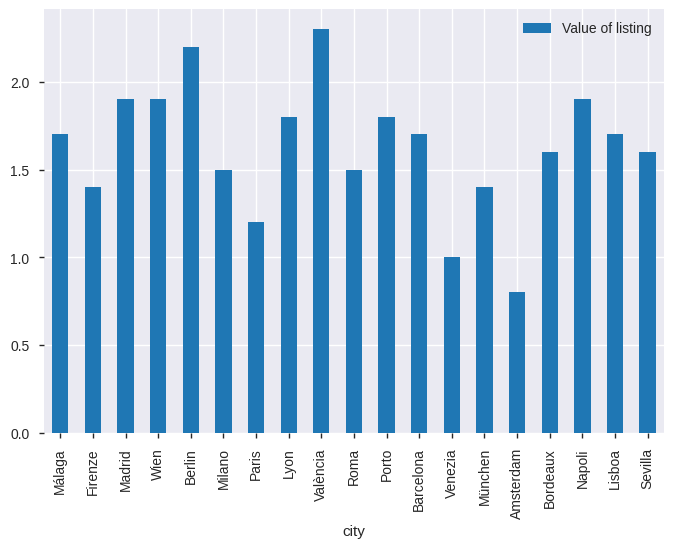

In [ ]:
eurozone = df_listings_analysis.filter(df_listings_analysis.city.isin(eurozone_cities))\
              .withColumn('value', F.col('review_scores_rating')/F.col('price'))\
              .groupby('city')\
              .agg(F.round(F.avg(F.col('value')),1).alias('Value of listing'))\
              .toPandas()
eurozone.plot.bar(x='city')
eurozone

## Insight 1 Findings:

using pyspark and the AirBnB database it is possible to see that the value of listings within the european union, where **Valencia** and **Berlin** are the cities with the highest value of property for short term rental

# Insight  2: The case of London

London is an extremely famous city and visited all year round, more than 
[30 million](https://www.condorferries.co.uk/uk-tourism-statistics#:~:text=London%20attracts%20around%2030%20million%20visitors%20from%20around%20the%20world%20every%20year.) tourists are attracted to the city every year. In addition, another important phenomenon of the city is the high property prices due to the high cost of living and the flow of foreign capital into the region. Do these two contexts reflect the price and valuation of the listings on the platform?


In [ ]:
# your code goes here
df_listings_london = df_listings_analysis.where(F.col('city')=='London')
df_listings_london

DataFrame[neighbourhood_cleansed: string, property_type: string, city: string, price: double, review_scores_rating: string, number_of_reviews: string, id: string]

## Part 1: Price distribution

Computing and visualizing the distribution of prices, for all prices up to and including the 95-percentile. Additionally, computing and visualising the distribution of prices, for all prices above the 95-percentile.

In [ ]:
# loading libraries
import pyspark.sql as sparksql
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.sql import Window
from pyspark.sql.functions import col
from pyspark.sql.functions import percent_rank,when

In [ ]:
df_listings_london = df_listings_london.sort(df_listings_london.price.desc())
df_listings_london.show(10)


+----------------------+-------------+------+-------+--------------------+-----------------+--------+
|neighbourhood_cleansed|property_type|  city|  price|review_scores_rating|number_of_reviews|      id|
+----------------------+-------------+------+-------+--------------------+-----------------+--------+
|  Hammersmith and F...|    Apartment|London|20000.0|                  91|               15|18519632|
|           Westminster|        House|London|20000.0|                  96|               10|19154075|
|             Islington|    Apartment|London|12345.0|                  98|               25| 9769911|
|             Islington|    Apartment|London|12345.0|                  89|               18| 9769063|
|             Islington|    Apartment|London|12345.0|                  95|               16| 9769683|
|           Westminster|    Apartment|London|12345.0|                null|                0|33514904|
|             Islington|    Apartment|London|12345.0|                  91|        

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import percent_rank,when
w = Window.partitionBy(df_listings_london.city).orderBy(df_listings_london.price)
percentiles_df_below = df_listings_london.withColumn('percentile',percent_rank().over(w))
result_below = percentiles_df_below.select(percentiles_df_below.city
                               ,when(percentiles_df_below.percentile <= 0.95,percentiles_df_below.price).alias('price'))

result_below = result_below.where(col("price").isNotNull())
df_below_percentile = result_below.toPandas()

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import percent_rank,when
w = Window.partitionBy(df_listings_london.city).orderBy(df_listings_london.price)
percentiles_df = df_listings_london.withColumn('percentile',percent_rank().over(w))
result_above = percentiles_df.select(percentiles_df.city
                               ,when(percentiles_df.percentile > 0.95,percentiles_df.price).alias('price'))

result_above = result_above.where(col("price").isNotNull())
df_above_percentile = result_above.toPandas()

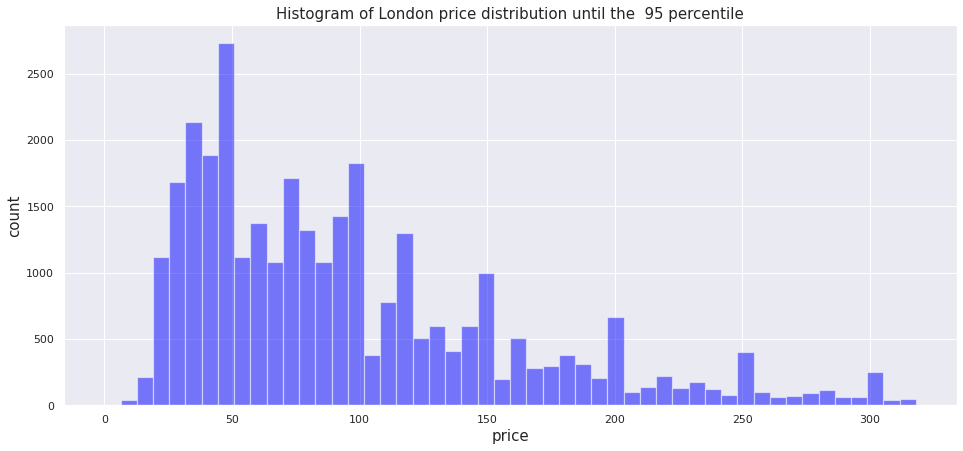

In [ ]:
plt.figure(figsize = [16,7])# set figuresize
plt.hist(df_below_percentile['price'],bins = 50,alpha = 0.5,color = 'blue', linewidth = 1.2)
plt.xlabel('price',size  =  15)
plt.ylabel('count',size  =  15)
plt.title('Histogram of London price distribution until the  95 percentile',size  =  15)
plt.show()

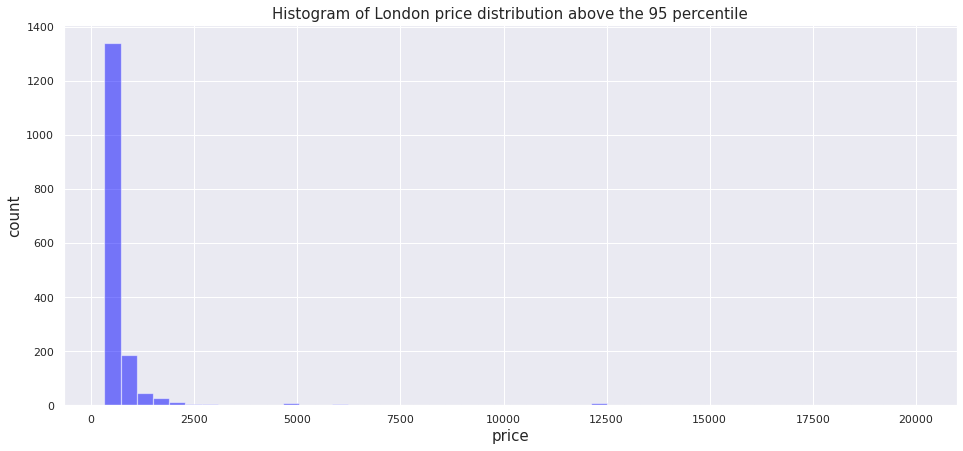

In [ ]:
plt.figure(figsize = [16,7])# set figuresize
plt.hist(df_above_percentile['price'],bins = 50,alpha = 0.5,color = 'blue', linewidth = 1.2)
plt.xlabel('price',size  =  15)
plt.ylabel('count',size  =  15)
plt.title('Histogram of London price distribution above the 95 percentile',size  =  15)
plt.show()

## Part 2: Prices by type of property

Computing and visualising the average price and average rating per type of property, for property types with 75 or more listings. 

In [ ]:
import pyspark.sql.functions as func

In [ ]:
# your code goes here
df_property_price = df_listings_london.cache().groupBy("property_type").agg(
     func.mean("price").alias("Mean_price"), 
     func.count(func.lit(1)).alias("Num Of Records"))
df_property_price = df_property_price.filter(F.col("Num of Records")>= 75)


In [ ]:
df_property_rating = df_listings_london.cache().groupBy("property_type").agg(
     func.mean("review_scores_rating").alias("Mean_rating"), 
     func.count(func.lit(1)).alias("Num Of Records"))
df_property_rating = df_property_rating.filter(F.col("Num of Records")>= 75)

In [ ]:
#transforming data in PySpark
df_property_final = df_property_price.join(df_property_rating, ['property_type'])
df_property_final = df_property_final.drop('Num Of Records')
#df_property_final = df_property_final.drop(df_property_final.columns[])
df_property_final = df_property_final.sort(df_property_final.Mean_rating.desc())
df_property_final = df_property_final.toPandas()
df_property_final

,property_type,Mean_price,Mean_rating
0,Townhouse,113.001657,95.200364
1,Loft,113.351613,94.856604
2,Condominium,143.811530,94.624260
3,Guest suite,78.177778,94.602410
4,House,123.320923,93.445457
5,Apartment,125.272881,92.634743
6,Guesthouse,136.606383,92.185714
7,Bed and breakfast,109.358885,91.589641
8,Boutique hotel,141.120879,91.061224
9,Other,90.254902,90.627451


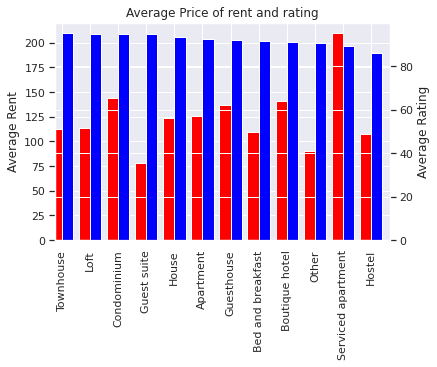

In [ ]:
#plotting
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()

width = 0.4

df_property_final.Mean_price.plot(kind='bar', color='red', ax=ax, width=width, position=1)
df_property_final.Mean_rating.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Average Rent')
ax2.set_ylabel('Average Rating')
plt.title('Average Price of rent and rating')
plt.xticks(range(0, 12),df_property_final['property_type'].tolist())

plt.show()

## Insight 2 Findings:
It is possible to see that the listing prices are high within the city of London, where the prices vary a lot in relation to the types of property but the total average of the valuations remains constant.

## Part 3: Best offering in the neighbourhood

The value of a listing is its rating divided by its price. I will compute and display a dataframe (with the columns I selected in the first part and those computed in this section) with the 3 highest valued listings in each neighbourhood, and having a value above 5.

Computing ranks based on value can be achieved using `pyspark.sql.window.Window`. This may produce equal ranks (i.e. when the value of two listings are the same).

In [ ]:
value_london = (df_listings_london.filter(F.col('review_scores_rating')!='NaN')
                             .withColumn('value',F.col('review_scores_rating')/F.col('price')))

window  = (pyspark.sql.window.Window.partitionBy('neighbourhood_cleansed')
                                                 .orderBy(F.desc('value')))

ranked_value = (value_london.withColumn('rank', F.rank().over(window))
                             .groupBy('neighbourhood_cleansed','value','rank')
                             .agg(F.avg(F.col('price')))
                             .filter(F.col('value')>5)
                             .filter(F.col('rank')<=3)
                             .toPandas())
pd.set_option('display.max_rows',len(ranked_value))
ranked_value

,neighbourhood_cleansed,value,rank,avg(price)
0,Barnet,5.157895,1,19.0
1,Brent,6.500000,1,14.0
2,Brent,6.266667,2,15.0
3,Brent,6.230769,3,13.0
4,Bromley,10.000000,1,10.0
5,Camden,5.625000,1,16.0
6,Camden,5.333333,2,15.0
7,Camden,5.294118,3,17.0
8,Croydon,5.111111,1,18.0
9,Croydon,5.105263,2,19.0


## Part 4: Activity by month

Activity is given by the number of reviews received in a given time period. Compute and visualise the activity based on month, that is, the total number of reviews given in January, February, etc..

An additional data source is necessary, I will download [this zip archive](https://data-download.compute.dtu.dk/c02807/reviews_london.csv.zip) which I must uncompress and place in the same folder as this notebook. It is loaded in the next cell and named `df_reviews_london`.

In [ ]:
df_reviews_london = load_csv_as_dataframe('drive/My Drive/Spark/reviews_london.csv')

In [ ]:
from pyspark.sql import functions as F
df_reviews_london.withColumn('month', F.split(F.col('date'), '-').getItem(1)) \
      .groupby('month')\
      .agg(F.count(F.col('listing_id')).alias('Activity'))\
      .sort('month').toPandas()

,month,Activity
0,01,51306
1,02,47816
2,03,61387
3,04,72617
4,05,83182
5,06,87616
6,07,98879
7,08,80682
8,09,69802
9,10,70231


## Part 5: Reviews per listing

Each London listing has received 0 or more reviews. 

Displaying a dataframe showing 1) The number of listings, 2) The average number of reviews a listing receives, 3) The standard deviation of the reviews per listing distribution, 4) The minimum number of reviews any listing has received, and 5) The maximum number of reviews any listing has received.

In [ ]:
df_reviews_london.groupby('listing_id')\
      .count()\
      .select(F.count('count').alias('Total Listings'),F.round(F.mean('count'),1).alias('Average Number of Reviews'), F.round(F.stddev('count'),1).alias('Stddev'), F.min('count').alias('Min'), F.max('count').alias('Max'))\
      .toPandas()


,Total Listings,Average Number of Reviews,Stddev,Min,Max
0,25920,32.3,50.9,1,690


# Insight 3: Word sentiment


The goal here is to determine what sentiment (positive or negative) words in reviews have. Roughly speaking, we want each word to be assigned a score based on the rating of the reviews in which the word occurs in the review comment. We'd expect words such as "clean", "comfortable", "superhost" to receive high scores, while words such as "unpleasant", "dirty", "disgusting" would receive low scores.

As individual reviews do not have a rating, we'll consider the rating of individual reviews to be the rating of its related listing (i.e. assuming each review gave the average rating (`review_scores_rating`) of the listing). 

The score of a word is given by the mean review rating over the reviews in which that word occurs in the comment. We require words to appear in at least 0.5% (1 in 200) listings, and to be at least 4 characters, for it to have a defined score.

Formally, when a word $w$ occurs in at least $0.5\%$ of listings and $|w| > 3$, its score is

$
\begin{align*}
score(w) = \frac{1}{|C_w|}\sum_{comment \in C_w} \text{review_rating}(comment)
\end{align*}
$
, where 
* $C_w = \{comment \mid w \text{ occurs in } \text{clean_text}(comment)\}$, the set (so no duplicates) of comments in which $w$ occurs, and
* $\text{clean_text}(comment)$ is the result of your `clean_text` function defined below, and
* $\text{review_rating}(comment)$ is the `review_scores_rating` of the listing which this $comment$ is related to.


## Part 1: Toy data

To get started we'll consider a toy example where the input is `df_sentiment_listings_toy` and `df_sentiment_reviews_toy` defined in the next code cell. I will provide an implementation of `calculate_word_scores_toy` in the subsequent code cell. My implementation should result in a query that when given the toy example dataframes as input and is materialized with `toPandas()` produces this table:

|    | word   |   word_score |   listing_occurences |   word_occurences |   comment_occurences |
|---:|:-------|-------------:|---------------------:|------------------:|---------------------:|
|  0 | aaaa   |      7       |                    3 |                 5 |                    5 |
|  1 | bbbb   |      6.66667 |                    2 |                 3 |                    3 |
|  2 | eeee   |      0       |                    1 |                 1 |                    1 |
|  3 | dddd   |      5       |                    1 |                 1 |                    1 |
|  4 | cccc   |      5       |                    2 |                 2 |                    2 |'

Observe that `word_occurences` and `comment_occurences` are the same as words occuring multiple times in a comment are counted once, and that `clean_text` is used to ignore casing and discard non-words. Additionally, any word occuring at least once will occur in more than 1 out of 200 listings on this toy data.

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType

schema_listings = StructType([
    StructField('id', StringType(), True),
    StructField('review_scores_rating', StringType(), True),
])
data_listings = [
    {'id': '0', 'review_scores_rating': '10'},
    {'id': '1', 'review_scores_rating': '5'},
    {'id': '2', 'review_scores_rating': '0'},
]
df_sentiment_listings_toy = spark.createDataFrame(data_listings, schema_listings)

schema_reviews = StructType([
    StructField('listing_id', StringType(), True),
    StructField('id', StringType(), True),
    StructField('comments', StringType(), True),
])
data_reviews = [
    {'listing_id': '0', 'id': '100', 'comments': 'aaaa bbbb          cccc'},
    {'listing_id': '0', 'id': '101', 'comments': 'aaaa bbbb '},
    {'listing_id': '0', 'id': '102', 'comments': 'aaaa aAAa          aaaa'},
    {'listing_id': '1', 'id': '103', 'comments': 'Aaaa bbb ccc'},
    {'listing_id': '1', 'id': '104', 'comments': 'dddd %ˆ&*'},
    {'listing_id': '2', 'id': '105', 'comments': 'AaaA'},
    {'listing_id': '2', 'id': '106', 'comments': 'bbbb ccc e&eˆˆee'},
    {'listing_id': '2', 'id': '107', 'comments': 'cccc cccc'},
]

df_sentiment_reviews_toy = \
    spark.createDataFrame(data_reviews, schema_reviews) \
        .select(F.col('listing_id'), F.col('id').alias('comment_id'), F.col('comments'))


In [ ]:
def clean_text(col):
    """
        Cleans the text (comment) associated with col. The
        cleaning should:
            1) Lower case the text
            2) Turn multiple whitespaces into single whitespaces
            3) Remove anything but letters, digits and whitespaces
        
        :col: A Spark Column object containing text data
        :returns: A Spark Column object.
    """
    col = F.regexp_replace(col,'[^a-zA-Z0-9 ]','')
    col = F.lower(col)
    col = F.trim(col)
    col = F.regexp_replace(col," +",' ')
    col = F.split(col, " ")
    col = F.concat_ws(" ", col)

    return col

def calculate_word_scores_toy(df_list, df_rev):
    """
        Calculates the word score over listings in df_list and
        reviews in df_rev. The table produced should have the 
        same columns as specified in part 1.
        
        :returns: A pandas DataFrame
    """
    final = df_rev.withColumn('comments', clean_text(F.col("comments"))) \
              .alias('df1') \
              .join(df_list, df_rev['listing_id'] == df_list['id']).select('df1.*', df_list.review_scores_rating) \
              .withColumn('words',F.explode(F.array_distinct(F.split('comments',' ')))) \
              .where(F.length(F.col('words'))>=4) \
              .groupBy('words').agg(F.avg('review_scores_rating').alias('word_score'), F.count_distinct('listing_id').alias('listing_ocurrences'), F.count('comments').alias('word_ocurrences'), F.count('comments').alias('comment_ocurrences')) 

    return final.toPandas()

calculate_word_scores_toy(df_sentiment_listings_toy, df_sentiment_reviews_toy)

,words,word_score,listing_ocurrences,word_ocurrences,comment_ocurrences
0,aaaa,7.000000,3,5,5
1,bbbb,6.666667,2,3,3
2,eeee,0.000000,1,1,1
3,dddd,5.000000,1,1,1
4,cccc,5.000000,2,2,2


## Part 2: London comments

In this part we'll calculate word scores for the comments related to London listings only. I should implement `count_relevant_listings` and `calculate_word_scores` (it will be an extension of your function from part 1) below. See the mathematical definition and docstrings for intended behaviour.

The function `calculate_word_scores` should return the top 10 and bottom 10 words by score. You should **not** use caching in your function.

Make sure your satisfy all conditions for a word to be scored (e.g. correctly calculating how many total listings scores are computed over). You should also consider whether your query is optimally structured in terms of computation time. Moreover, `pd.set_option('display.max_rows', <n>)` should be set with sufficiently high `n` to show all words.

In [ ]:
import pandas as pd
def count_relevant_listings(df_list, df_rev):
    """
        Calculates the number of listings in df_list that has a 
        review in df_rev. A listing that is reviewed more than once
        should only count as one.
        
        :returns: An integer 
    """
    df_list = df_list.alias('df_list')
    merged = df_list.join(df_rev, df_list.id == df_rev.listing_id, 'inner').select(df_list['id'])
    result = merged.select(F.countDistinct("id"))

    return result.collect()[0][0]

def calculate_word_scores(df_list, df_rev, listings_count):
    """
        Calculates the word score over listings in df_list and
        reviews in df_rev. The value of listings_count should 
        be used to filter out words not occuring frequently enough
        in comments. The table produced should have the same columns
        as in part 1 of this exercise.
        
        :returns: A pandas DataFrame containing the top 10 and 
        bottom 10 words based on their word score, sorted by word_score.
    """
    final = df_rev.withColumn('comments', clean_text(F.col("comments")))\
            .alias('df1')\
            .join(df_list,df_rev['listing_id'] == df_list['id']).select('df1.*', df_list.review_scores_rating)\
            .withColumn('words',F.explode(F.array_distinct(F.split('comments',' '))))\
            .where(F.length(F.col('words'))>=4)\
            .groupBy('words').agg(F.avg('review_scores_rating').alias('word_score'), F.count_distinct('listing_id').alias('listing_ocurrences'), F.count('comments').alias('word_ocurrences'), F.count('comments').alias('comment_ocurrences'))\
            .where(F.col('listing_ocurrences')/listings_count > 0.005)\
            .toPandas()

    pandas_final = pd.concat([final.nsmallest(n=10, columns=['word_score']),final.nlargest(n=10, columns=['word_score'])]).sort_values(by=['word_score'], ascending = False)
    


    return pandas_final

In [ ]:
# should not be modified
from IPython.display import display

relevant_listings_count_london = count_relevant_listings(df_listings_london, df_reviews_london)
word_scores_london_timing = %timeit -o -n1 -r1 display( \
    calculate_word_scores(df_listings_london, \
                          df_reviews_london, \
                          relevant_listings_count_london) \
)
pd.set_option('display.max_rows', 20)
word_scores_london_timing.best

,words,word_score,listing_ocurrences,word_ocurrences,comment_ocurrences
5293,granola,97.543210,152,243,243
3440,homemade,97.268557,475,1199,1199
2322,superhost,97.088050,665,795,795
1183,yogurt,97.036458,243,384,384
2952,yoghurt,97.014019,146,214,214
1031,baked,96.936803,295,538,538
4312,muesli,96.935115,178,262,262
2308,divine,96.847458,161,177,177
2785,exquisite,96.675182,257,274,274
3343,crouch,96.618982,153,727,727


1 loop, best of 1: 2min 38s per loop


158.8710063279999

## Part 3: Scalability

The listings from London make up a little less than 2% of the entire set of listings. In this part we're interested in how the amount of input data impacts computation time, that is, how `calculate_word_scores` scales as data increases. To this end, we've made multiple samples of the dataset of varying sizes.

The experiment reuses `count_relevant_listings` and `calculate_word_scores` that you implemented in part 2. Code needed for this part is provided to you. 

My task is to obtain the data sources, run the code cells below, and explain the results I get. Specifically, I must explain any non-linear relationship between data size and computation time, using the markdown cell at the end of this part. In finding explanations, using the Spark UI to investigate the anatomy of your queries may prove valuable. Once I've found an explanation, state a potential solution to remedy the issue.

*Implementation note* Make sure you've properly configured `spark.driver.memory` (it requires a kernel restart to update the value). It may be that your query fails on the larger samples due to running out of compute resources. This is likely caused by a suboptimal `calculate_word_scores`, but can be from reaching the limits of your hardware. If you think the latter is the case, argue for this perspective in the markdown cell.

My data sources are (uncompress and place in the same directory as this notebook):
* 0.25%: [listings](https://data-download.compute.dtu.dk/c02807/listings_0-dot-25percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_0-dot-25percent.csv.zip)
* 0.5%: [listings](https://data-download.compute.dtu.dk/c02807/listings_0-dot-5percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_0-dot-5percent.csv.zip)
* 1%: [listings](https://data-download.compute.dtu.dk/c02807/listings_1-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_1-dot-0percent.csv.zip)
* 2%: [listings](https://data-download.compute.dtu.dk/c02807/listings_2-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_2-dot-0percent.csv.zip)
* 4%: [listings](https://data-download.compute.dtu.dk/c02807/listings_4-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_4-dot-0percent.csv.zip)
* 8%: [listings](https://data-download.compute.dtu.dk/c02807/listings_8-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_8-dot-0percent.csv.zip)
* 12.5%: [listings](https://data-download.compute.dtu.dk/c02807/listings_12-dot-5percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_12-dot-5percent.csv.zip)
* 16%: [listings](https://data-download.compute.dtu.dk/c02807/listings_16-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_16-dot-0percent.csv.zip)
* 25%: [listings](https://data-download.compute.dtu.dk/c02807/listings_25-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_25-dot-0percent.csv.zip)
* 50%: [listings](https://data-download.compute.dtu.dk/c02807/listings_50-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_50-dot-0percent.csv.zip)
* 75%: [listings](https://data-download.compute.dtu.dk/c02807/listings_75-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_75-dot-0percent.csv.zip)
* 100%: [listings](https://data-download.compute.dtu.dk/c02807/listings_100-dot-0percent.csv.zip), [reviews](https://data-download.compute.dtu.dk/c02807/reviews_100-dot-0percent.csv.zip)

In [ ]:
import time
def calculate_word_scores_timed(percent_str):
    """
        Calculates word scores over a sampled dataset indicated
        by percent_str.
        
        :returns: A dictionary with benchmarking information and
        the calculated values.
    """
    df_listings = load_csv_as_dataframe(f'drive/My Drive/Spark/listings_{percent_str}percent.csv')
    df_reviews = load_csv_as_dataframe(f'drive/My Drive/Spark/reviews_{percent_str}percent.csv')
    
    listings_count = count_relevant_listings(df_listings, df_reviews)

    start = time.time()
    df_word_scores = calculate_word_scores(df_listings, df_reviews, listings_count)
    end = time.time()
    return {
        'percentage': float(percent_str.replace('-dot-', '.')), 
        'time_spent': f"{end - start:.2f}", 
        'relevant_listings': listings_count, 
        'df': df_word_scores
    }

In [ ]:
data_percentages = [
    '0-dot-25', '0-dot-5', '1-dot-0', '2-dot-0', '4-dot-0', '8-dot-0',
    '12-dot-5', '16-dot-0', '25-dot-0'
]
score_data = {
    percentage_str: calculate_word_scores_timed(percentage_str) for percentage_str in data_percentages
}

In [ ]:
score_data['50-dot-0'] = calculate_word_scores_timed('50-dot-0')

In [ ]:
score_data['75-dot-0'] = calculate_word_scores_timed('75-dot-0')

In [ ]:
score_data['100-dot-0'] = calculate_word_scores_timed('100-dot-0')

In [ ]:
df_scores_scaling = pd.DataFrame(score_data).T.convert_dtypes()
df_scores_scaling.time_spent = df_scores_scaling.time_spent.astype(float)

# Access to word scores of 2 percent data: df_scores_scaling.loc['2-dot-0'].df
df_scores_scaling

,percentage,time_spent,relevant_listings,df
0-dot-25,0.25,15.53,2529,words word_score ... word_ocurre...
0-dot-5,0.50,24.58,5040,words word_score ... word_oc...
1-dot-0,1.00,49.67,10143,words word_score ... word_ocurr...
2-dot-0,2.00,97.55,20575,words word_score ... word_ocurre...
4-dot-0,4.00,197.48,40919,words word_score ... word_oc...
8-dot-0,8.00,348.28,81756,words word_score ... word_oc...
12-dot-5,12.50,545.83,128202,words word_score ... word_oc...
16-dot-0,16.00,690.08,163627,words word_score ... word_oc...
25-dot-0,25.00,1092.39,256183,words word_score ... word_oc...
50-dot-0,50.00,2185.39,511667,words word_score ... word_oc...


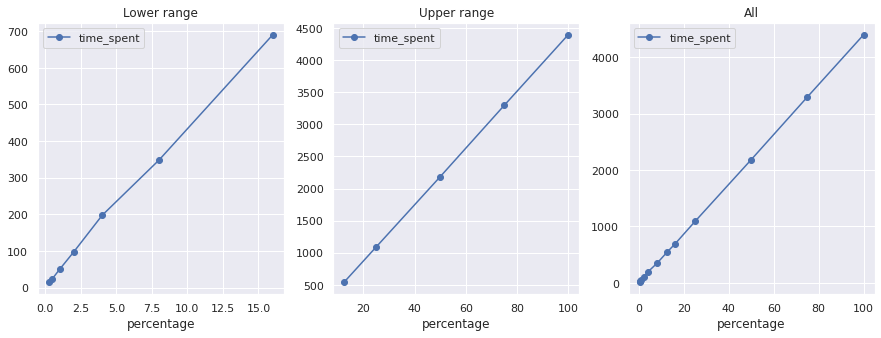

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

lower_range = ['0-dot-25', '0-dot-5', '1-dot-0', '2-dot-0', '4-dot-0', '8-dot-0', '16-dot-0']
df_scores_scaling[df_scores_scaling.index.isin(lower_range)] \
    .plot.line(x='percentage', y='time_spent', ax=axes[0], style='-o', title='Lower range')
df_scores_scaling[~df_scores_scaling.index.isin(lower_range)] \
    .plot.line(x='percentage', y='time_spent', ax=axes[1], style='-o', title='Upper range')
_ = df_scores_scaling \
    .plot.line(x='percentage', y='time_spent', ax=axes[2], style='-o', title='All')

As we can see the results obtained are very consistent throughout every percentage. Very very small non linearities can be seen on small percentages of data, but nothing major. These are due to the specific run, as we know it's not always going to take exactly the same time and when comparing at a very low percentage even 1 second makes a big difference in the linearity. 

When analyzing the query itself the only improvement I could think of is to find a way to filter out words at an earlier step on the query itself, in order to limit the amount of data for which we calculate word_ocurrence, comment_ocurrence ecc. The only way to do this would be to split the code into two queries and run the second one filtering out all words which do not ful-fill the requirements. I am not sure this would actually improve the time the query takes over-all though, but that is the only loss of resources I can determine. 

We can see that the query is linear in percentages up to 4% percent and after 8%. Our query is highly dependent on exploding all uniques words of a comment. As I said, at low percentages even small variations in computation time (which may also occur due simply to computations not being consistent to the second) make a big difference. Hence this small difference may also be due to the specific comments present in the small percentages of data and the amount of unique words inside, as what is increasing is the amount of listings and reviews, but percentages of data don't take into consideration the amount of data inside the review itself (I think, hard to know having access to the data). Or it may be due to the fact that with larger amounts of data a larger percentage of words is dropped when we condition them to being longer than 4 letters. We could address this by implementing it inside the cleaner, which I believe would have been better anyway as we are splitting into sub-strings in order to clean the text.


## Part 4: Robustness

In this part we'll explore robustness of our word scores, using the values we computed in part 3. We'll do so by comparing top/bottom words for three different samples of the dataset. Specifically, the scores from your maximum (e.g. 100%) computed sample are to be compared with the 12.5% and 2.0% scores.

Compute and display a dataframe that accounts for any word found in either of the three samples' top/bottom words, and additionally shows the related `word_score` and `word_occurences` values.

Note that `df_scores_scaling.loc['100-dot-0'].df` provides the word scores dataframe of the 100% sample (similarly for the other two). For this part you should rely on pandas functionality only.  Moreover, `pd.set_option('display.max_rows', <n>)` should be set with sufficiently high `n` to show all rows.

In [ ]:
# your code goes here
# your code goes here
pd.set_option('display.max_rows',60)
import pandas as pd
df_100 = df_scores_scaling.loc['100-dot-0'].df
df_12_5 = df_scores_scaling.loc['12-dot-5'].df
df_2 = df_scores_scaling.loc['2-dot-0'].df


df_100['Percentage'] = '100%'
df_12_5['Percentage'] = '12.5%'
df_2['Percentage'] = '2%'

# I know this is not asked but I believe it to be useful to show what percentage the word belongs to
columns = ['words', 'word_score', 'word_ocurrences', 'Percentage']
result = pd.concat([df_100, df_12_5, df_2]).reset_index()[columns].round(2)

# Finally, even more I think it would be interesting to have a view of the single words and where they are coming from
# If this is not what you want just look below
best = result.groupby(by = 'words')['word_score', 'word_ocurrences', 'Percentage'].agg(lambda x: list(x))
best


# Case in which we don't add the column for the percentage

#columns = ['words', 'word_score', 'word_occurences']
#result = pd.concat([df_100, df_12_5, df_2]).reset_index()[columns]
#result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,word_score,word_ocurrences,Percentage
words,,,
austin,[97.98],[2003],[2%]
baked,"[97.36, 97.41]","[22464, 395]","[100%, 2%]"
beverages,[97.55],[322],[2%]
breweries,[97.45],[375],[2%]
cockroaches,"[88.2, 87.91]","[6835, 875]","[100%, 12.5%]"
dirty,"[88.33, 88.51, 88.27]","[84764, 10324, 1794]","[100%, 12.5%, 2%]"
disgusting,"[86.46, 87.15, 86.7]","[6975, 879, 130]","[100%, 12.5%, 2%]"
filthy,"[86.98, 87.04, 86.35]","[8072, 978, 147]","[100%, 12.5%, 2%]"
goodies,"[97.33, 97.53]","[28407, 564]","[100%, 2%]"


In [ ]:
result.sort_values('word_score', ascending = False)

,words,word_score,word_ocurrences,Percentage
40,austin,97.98,2003,2%
20,nashville,97.66,15319,12.5%
41,magazine,97.56,488,2%
42,beverages,97.55,322,2%
43,homemade,97.55,964,2%
44,prosecco,97.54,241,2%
45,goodies,97.53,564,2%
21,thoughtfulness,97.52,1263,12.5%
0,nashville,97.52,115358,100%
1,thoughtfulness,97.48,9900,100%
